## Enunciado
Dado un proyecto con los datos que se muestran en la tabla siguiente, se pide:
   1. Dibujar el diagrama Pert y determinar el camino crítico.
   2. Probabilidad de terminar el proyecto antes de 9 periodos.
   3. Reducir la duración del proyecto hasta 10 periodos con el mínimo incremento posible de coste.
   4. Si el número máximo de recursos durante las 6 primeras semanas es 4, determinar si será posible realizar el proyecto en el tiempo obtenido en el apartado 1.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null
%pip install -q amplpy                    > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

datos_enunciado= pd.DataFrame([
#actividad, precedentes, duracion, desviacion,  cur, recursos, duracion_tope
  (   'A',     '--- ',       3,         2,        5,      1,       1  ),
  (   'B',     '--- ',       2,         1,        5,      1,       1  ),
  (   'C',     'B   ',       4,         2,       25,      1,       2  ),
  (   'D',     'A   ',       2,         1,      -10,      2,       1  ),
  (   'E',     'A   ',       4,         0,        1,      1,       4  ),
  (   'F',     'E   ',       3,         1,        5,      1,       2  ),
  (   'G',     'C,D ',       1,         0,      -20,      2,       1  ),
  (   'H',     'C,D ',       5,         3,        1,      1,       2  ),
  (   'I',     'F,G,H',      1,         0,        1,      1,       1  ),
  (   'J',     'F,G  ',      2,         0,       -1,      1,       2 ),
  (   'K',     'F,G  ',      1,         0,        5,      2,       1  ),
], columns=['activity', 'predecessor', 'duration', 'standard_deviation', 'ucr', 'resources', 'cap_duration']).set_index('activity')
datos_enunciado

,predecessor,duration,standard_deviation,ucr,resources,cap_duration
activity,,,,,,
A,---,3,2,5,1,1
B,---,2,1,5,1,1
C,B,4,2,25,1,2
D,A,2,1,-10,2,1
E,A,4,0,1,1,4
F,E,3,1,5,1,2
G,"C,D",1,0,-20,2,1
H,"C,D",5,3,1,1,2
I,"F,G,H",1,0,1,1,1


## Solución
### Apartado 1
> Dibujar el diagrama Pert y determinar el camino crítico.

In [3]:
from pmule import PredecessorTable, ProjectGraph

In [4]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K
activities,,,,,,,,,,,
A,,,,,,,,,,,
B,,,,,,,,,,,
C,,True,,,,,,,,,
D,True,,,,,,,,,,
E,True,,,,,,,,,,
F,,,,,True,,,,,,
G,,,True,True,,,,,,,
H,,,True,True,,,,,,,
I,,,,,,True,True,True,,,


In [5]:
datos_proyecto = datos_enunciado.copy()
datos_proyecto_apartado_1 = datos_proyecto.copy() # La necesitaremos en el apartado 4

In [6]:
proyecto = prelaciones.create_project()

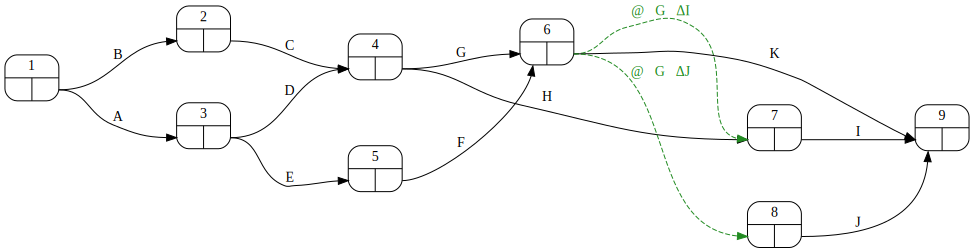

In [7]:
proyecto.pert(ranksep=1.5, nodesep=0.7)

In [8]:
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,2.0,3.0,,,,,,,0.0
2,,,,4.0,,,,,,2.0
3,,,,2.0,4.0,,,,,3.0
4,,,,,,1.0,5.0,,,6.0
5,,,,,,3.0,,,,7.0
6,,,,,,,0.0,0.0,1.0,10.0
7,,,,,,,,,1.0,11.0
8,,,,,,,,,2.0,10.0
9,,,,,,,,,,12.0
late,0.0,2.0,3.0,6.0,7.0,10.0,11.0,10.0,12.0,


In [9]:
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,2,2
3,3,3
4,6,6
5,7,7
6,10,10
7,11,11
8,10,10
9,12,12


In [10]:
resultados_pert['activities'][['H_total']]

,H_total
@∇G⤑ΔI,1
@∇G⤑ΔJ,0
A,0
B,0
C,0
D,1
E,0
F,0
G,3
H,0


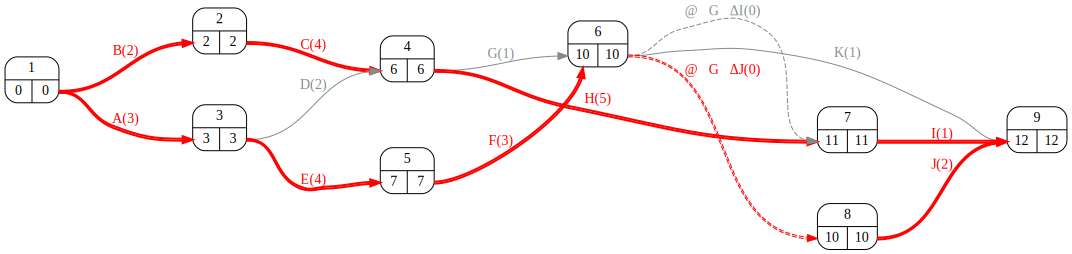

In [11]:
proyecto.pert(durations=datos_proyecto['duration'], ranksep=1.5, nodesep=0.7)

In [12]:
proyecto.critical_path(durations=datos_proyecto['duration'])

{'Route_4': ['B', 'C', 'H', 'I'], 'Route_11': ['A', 'E', 'F', '@∇G⤑ΔJ', 'J']}

## Apartado 2
> Probabilidad de terminar el proyecto antes de 9 periodos.

La duración media del proyecto la conocemos del apartado 1.

In [13]:
duracion_media_proyecto = proyecto.duration(durations=datos_proyecto['duration'])
duracion_media_proyecto

12

Para determinar la desviación típica debemos obtener en cada rama del camino crítico la suma de las varianzas, y quedarnos con la mayor.

In [14]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])
desviacion_proyecto

Variance path: Route_4 : 14
Variance path: Route_11 : 5
Project duration variance: 14
Project duration standard deviation: 3.7416573867739413


3.7416573867739413

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad:

In [15]:
import scipy
from scipy.stats import norm

probabilidad = norm.cdf(9, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad * 100

21.133903708531776

## Apartado 3
> Reducir la duración del proyecto hasta 10 periodos con el mínimo incremento posible de coste.

In [16]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2)
ackoff

D shape (11,)
Path matrix shape (11, 11)


Step: 0,	 Best option: ['H', 'A'], 	 Cost: 6, 	 Critical paths: ['Route_4', 'Route_11']
Step: 1,	 Best option: ['H', 'A'], 	 Cost: 6, 	 Critical paths: ['Route_4', 'Route_11']





,A,B,C,D,E,F,G,H,I,J,K,0,1,2
Route_1,,5.0,25.0,,,,-20.0,,,,5.0,8.0,8.0,8.0
Route_2,,5.0,25.0,,,,-20.0,,1.0,,,8.0,8.0,8.0
Route_3,,5.0,25.0,,,,-20.0,,,-1.0,,9.0,9.0,9.0
Route_4,,5.0,25.0,,,,,1.0,1.0,,,12.0,11.0,10.0
Route_5,5.0,,,-10.0,,,-20.0,,,,5.0,7.0,6.0,5.0
Route_6,5.0,,,-10.0,,,-20.0,,1.0,,,7.0,6.0,5.0
Route_7,5.0,,,-10.0,,,-20.0,,,-1.0,,8.0,7.0,6.0
Route_8,5.0,,,-10.0,,,,1.0,1.0,,,11.0,9.0,7.0
Route_9,5.0,,,,1.0,5.0,,,,,5.0,11.0,10.0,9.0
Route_10,5.0,,,,1.0,5.0,,,1.0,,,11.0,10.0,9.0


El coste de la reducción ha sido:

In [17]:
2 * datos_proyecto.loc['A', 'ucr'] + 2 * datos_proyecto.loc['H', 'ucr']

12

## Apartado 4
> Si el número máximo de recursos durante las 6 primeras semanas es 4, determinar si será posible realizar el proyecto en el tiempo obtenido en el apartado 1.

### Situación inicial de partida

Representamos la demanda de recursos por periodo utilizando un diagrama de Gantt.

In [18]:
proyecto_asignacion = proyecto.copy()
proyecto_asignacion.gantt(datos_proyecto, 'duration', 'resources', total='fila', holguras = True)

,1,2,3,4,5,6,7,8,9,10,11,12,H_total
A,1,1,1,,,,,,,,,,0.000000
B,1,1,,,,,,,,,,,0.000000
C,,,1,1,1,1,,,,,,,0.000000
D,,,,2,2,,,,,,,,1.000000
E,,,,1,1,1,1,,,,,,0.000000
F,,,,,,,,1,1,1,,,0.000000
G,,,,,,,2,,,,,,3.000000
H,,,,,,,1,1,1,1,1,,0.000000
I,,,,,,,,,,,,1,0.000000
J,,,,,,,,,,,1,1,0.000000


Se concluye por tanto que la restricción de recursos impuesta no implica ningún problema.